In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Lambda, LSTM, RepeatVector
from keras.models import Model
from keras import backend as K
from keras import metrics
from scipy.stats import norm
import pandas as pd
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


# Read Data Set

In [2]:
df = pd.read_csv("data/EEG_Eye_State.arff",comment="@",header = None)

+ Extract the label

In [3]:
y = df[df.columns[-1]]
del df[df.columns[-1]]

+ filter outliers

In [4]:
highest_quantile = np.percentile(df,99,axis=0)
df[df > highest_quantile] = np.nan
df = df.fillna(df.quantile(0.99))

In [5]:
lowest_quantile = np.percentile(df,1,axis=0)
df[df < lowest_quantile] = np.nan
df = df.fillna(df.quantile(0.01))

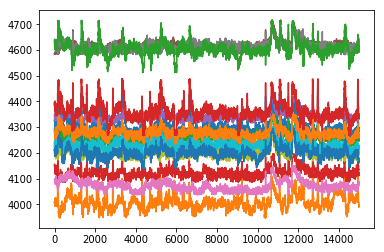

In [6]:
_ = plt.plot(df)

Standardize using a z-score: 

$$z_{i,d} = \frac{x_{i,d} - \mu_d}{\sigma_d}$$

+ $\mu_d$ : mean along dimension $d$
+ $\sigma_d$ : std along dimension $d$
+ $x_{i,d}$ : $i$-th coordinate along dimension $d$

In [7]:
df = (df - df.mean()) * 1./(df.std()+0.00001)

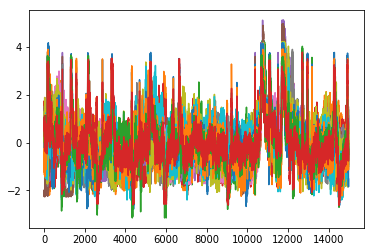

In [8]:
_ = plt.plot(df)

# Variational Auto Encoder LSTM

## Sampling

In [9]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

## Loss

In [10]:
def vae_loss(x, x_decoded_mean_squash):
    xent_loss = metrics.binary_crossentropy(x, x_decoded_mean_squash)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return K.mean(xent_loss + kl_loss)

# Encoder

### Meta Parameters

In [26]:
input_dim = df.shape[1]
timesteps = 32
jump = 5
nb_epoch = 10

validation_split = 0.1
batch_size = 50

lstm_1_size = 30
lstm_2_size = 15
intermediate_dim = 10
latent_dim = 2

epsilon_std = 0.01

## Generate the time series

In [27]:
indexes = [range(i,i+timesteps) for i in range(0,df.shape[0]-jump-timesteps,jump)]
X = df.values[indexes]

## Encoder

In [28]:
inputs = Input(shape=(timesteps, input_dim))
encoded_h1 = LSTM(lstm_1_size,return_sequences=True)(inputs)
encoded_h2 = LSTM(lstm_2_size)(encoded_h1)
encoded_hidden = Dense(intermediate_dim, activation='tanh')(encoded_h2)

z_mean = Dense(latent_dim)(encoded_hidden)
z_log_sigma = Dense(latent_dim)(encoded_hidden)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [29]:
sequence_encoder = Model(inputs=inputs, outputs=z_mean)
sequence_encoder.compile(optimizer='rmsprop', loss=vae_loss)

## Decoder

In [30]:
_decoded_hidden = Dense(intermediate_dim, activation='tanh')
_decoded_repeated = RepeatVector(timesteps)
_decoded_h2 = LSTM(lstm_2_size,return_sequences=True)
_decoded_h1 = LSTM(lstm_1_size,return_sequences=True)
_decoded = LSTM(input_dim,return_sequences=True)

In [31]:
decoded_inputs = Input(shape = (latent_dim,))
decoded_hidden = _decoded_hidden(decoded_inputs)
decoded_repeated = _decoded_repeated(decoded_hidden)
decoded_h2 = _decoded_h2(decoded_repeated)
decoded_h1 = _decoded_h1(decoded_h2)
decoded =  _decoded(decoded_h1)

In [32]:
sequence_decoder = Model(decoded_inputs, decoded)
sequence_decoder.compile(optimizer='rmsprop', loss=vae_loss)

## Auto Encoder

In [33]:
ae_decoded_hidden = _decoded_hidden(z)
ae_decoded_repeated = _decoded_repeated(ae_decoded_hidden)
ae_decoded_h2 = _decoded_h2(ae_decoded_repeated)
ae_decoded_h1 = _decoded_h1(ae_decoded_h2)
ae_decoded =  _decoded(ae_decoded_h1)

In [34]:
sequence_autoencoder = Model(inputs, ae_decoded)
sequence_autoencoder.compile(optimizer='rmsprop', loss=vae_loss)

In [35]:
sequence_autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 32, 14)        0                                            
____________________________________________________________________________________________________
lstm_6 (LSTM)                    (None, 32, 30)        5400        input_3[0][0]                    
____________________________________________________________________________________________________
lstm_7 (LSTM)                    (None, 15)            2760        lstm_6[0][0]                     
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 10)            160         lstm_7[0][0]                     
___________________________________________________________________________________________

# Fit 

In [40]:
import tensorflow as tf
tf.flags.DEFINE_integer("batch_size", 32, "Batch size during training")
tf.flags.DEFINE_integer("eval_batch_size", 32, "Batch size during evaluation")

In [41]:
filepath_loss = "checkpoint/better_loss_.hdf5"
checkpoint_loss = ModelCheckpoint(filepath_loss,
                                  monitor='loss',
                                  verbose=0,
                                  save_best_only=True,
                                  mode='auto')
filepath_val_loss = "checkpoint/better_val_loss_epoch-{epoch:02d}.hdf5"   
checkpoint_val_loss = ModelCheckpoint(filepath_val_loss,
                                      monitor='val_loss',
                                      verbose=0,
                                      save_best_only=True,
                                      mode='auto')
callbacks_list = [checkpoint_loss,
                  checkpoint_val_loss]
history = sequence_autoencoder.fit(X,
                                   X,
                                   32,
                                   nb_epoch,
                                   callbacks = callbacks_list,
                                   validation_split=validation_split,
                                   verbose = 1,
                                   shuffle = True)

Train on 2690 samples, validate on 299 samples
Epoch 1/10
2688/2690 [============================>.] - ETA: 0s - loss: -4.1671

InvalidArgumentError: Incompatible shapes: [2,32] vs. [2]
	 [[Node: add_57 = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Mean_30, mul_84)]]

Caused by op u'add_57', defined at:
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Library/Python/2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Python/2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Python/2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Library/Python/2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Python/2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Python/2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-d0419f9e621a>", line 2, in <module>
    sequence_autoencoder.compile(optimizer='rmsprop', loss=vae_loss)
  File "/Library/Python/2.7/site-packages/keras/engine/training.py", line 910, in compile
    sample_weight, mask)
  File "/Library/Python/2.7/site-packages/keras/engine/training.py", line 436, in weighted
    score_array = fn(y_true, y_pred)
  File "<ipython-input-10-64b81279e8e7>", line 4, in vae_loss
    return K.mean(xent_loss + kl_loss)
  File "/Library/Python/2.7/site-packages/tensorflow/python/ops/math_ops.py", line 884, in binary_op_wrapper
    return func(x, y, name=name)
  File "/Library/Python/2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 73, in add
    result = _op_def_lib.apply_op("Add", x=x, y=y, name=name)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes: [2,32] vs. [2]
	 [[Node: add_57 = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Mean_30, mul_84)]]


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [170]:
history.history

{'loss': [-2.6506093326104461,
  -3.7239708176142052,
  -3.9333363715517637,
  -4.1674987825988747,
  -1.2618933171477675],
 'val_loss': [-4.1177322231606892,
  -4.4891088722541577,
  -4.6715163868107528,
  -4.6442779139132799,
  -1.4833814420030269]}